# タイタニック生存予測 ランダムフォレスト

- 問題提起
- データ取得
- データ可視化
- 前処理
- モデル選択
- データセット分割
- 学習
- 評価


## 問題定義
ランダムフォレストを用いて、生存を予測する。


## データ取得

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')

In [6]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# df.sample
# n：件数分取得
# frac：10%取得
df_train.sample(n=5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
883,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
444,445,1,3,"Johannesen-Bratthammer, Mr. Bernt",male,NaN,0,0,65306,8.1125,NaN,S
754,755,1,2,"Herman, Mrs. Samuel (Jane Laver)",female,48.0,1,2,220845,65.0000,NaN,S
335,336,0,3,"Denkoff, Mr. Mitto",male,NaN,0,0,349225,7.8958,NaN,S
687,688,0,3,"Dakic, Mr. Branko",male,19.0,0,0,349228,10.1708,NaN,S


In [8]:
df_train.shape

(891, 12)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# 前処理について
- 前処理とは何か
- なぜ前処理を行う必要があるのか
- 前処理は具体的に何を行うか（3つ以上記述せよ）
- 前述した具体的な前処理について、その前処理を行うと何を得ることができるか（記述したそれぞれの前処理例について記述せよ）

**回答**  
前処理とは、機械学習アルゴリズムで構築されたモデルでの**分析を正常に稼働させる**ため、取得データを**各値の関係性を損ねることなく加工**する作業。  
具体的には、

**１）欠損値補完**  
取得データにnull値があると、モデルにデータが渡せないので、最適な数値に変換する必要がある。(カテゴリカルの場合は、適当な文字列に変換)
- データ数が多く、欠損値のあるデータが限りなく少ない場合、データごと削除（**リストワイズ法**）
- 値がランダムに欠損しているということが確認できている場合、カラムの平均を欠損値に代入（**平均代入法**）
- 上記いずれにも該当しない場合、連鎖方程式(MICE)による多重代入法で、欠損値を補完

**２）カテゴリカルデータのエンコーディング（数値化）**  
取得データにカテゴリカル値があると、モデルにデータが渡せないので、最適な数値に変換する必要がある。
- カテゴリカル値が尺度や順位を意味している場合、各分類を数値に変換
- カテゴリカル値が名義である場合、カテゴリカル値の分類数分のカラムを増やし、バイナリ真理値（one-hot表現）に変換

**３）スケーリング**  
範囲の大きい特徴量に影響を受けすぎることによる過学習を防ぐため、数的関係を損ねることなく、数値の範囲を統一させる必要がある。
- データに外れ値がなく、一様分布の場合、0〜１の範囲に正規化させる。
- 上記以外の場合、平均が0、標準偏差が１に標準化させる。




# データを確認する際にどのような点を見るとよいか、3つ以上記述せよ。

**回答**  
- 欠損値の有無を確認。データ数が多く、欠損値データが限りなく少ない場合はデータ削除。でなければ、欠損値に数値を補完。
- データのタイプを確認。カテゴリカルデータが見つかれば、エンコーディングを実施。
- データをプロットし、外れ値の有無を確認。外れ値がある場合、標準化でスケール変換させる。

# 前処理を行う

In [10]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df

def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(df_train)
data_test = transform_features(df_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


In [11]:
data_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,892,3,male,Young Adult,0,0,1_quartile,N,"Kelly,",Mr.
1,893,3,female,Adult,1,0,1_quartile,N,"Wilkes,",Mrs.
2,894,2,male,Senior,0,0,2_quartile,N,"Myles,",Mr.
3,895,3,male,Young Adult,0,0,2_quartile,N,"Wirz,",Mr.
4,896,3,female,Student,1,1,2_quartile,N,"Hirvonen,",Mrs.


In [12]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])

    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


In [13]:
data_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,892,3,1,7,0,0,0,7,401,19
1,893,3,0,0,1,0,0,7,843,20
2,894,2,1,3,0,0,1,7,552,19
3,895,3,1,7,0,0,1,7,851,19
4,896,3,0,4,1,1,1,7,342,20


# 前処理の内容について
- 下記メソッドがそれぞれ何を行っているか記述せよ  
- それぞれなぜそのようなことを行っているか記述せよ（それによって得られるメリットまで考察すること）


**回答**  
**simplify_ages**  
年齢という数値に影響を受けすぎないようにするため、年齢層にグループ分け  
→過学習を防ぎ、モデルの精度を向上させる

**simplify_cabins**  
null値のままでは、モデルにデータを渡せないため、まずカテゴリカルの欠損値を文字列に変換  
→後のencode_featuresで数値データに変換できる  
部屋番号に影響を受けすぎないようにするため、部屋番号をグループ分け  
→過学習を防ぎ、モデルの精度を向上させる

**simplify_fares**  
乗船料金という数値に影響を受けすぎないようにするため、料金帯にグループ分け  
→過学習を防ぎ、モデルの精度を向上させる

**format_name**  
「名前」を「姓」と「接頭辞」に分割し、それぞれの新たな特徴量カラムを増設
→生存率と関わりがありそうな、新たな特徴量を増設することで、モデルの精度を向上させる

**drop_features**  
生存率に関わりのない「名前」と「乗客ID」「乗船した港」のカラムを削除  
→無駄に学習させず、モデルの精度を向上させる。

** encode_features **  
乗船料金、部屋番号、年齢、性別、姓、名前接頭辞の各カテゴリカルグループを数値に変換  
→モデルにデータを渡すことができる。


# モデル選択について ★

- 今回は、生存予測（分類）を行いますが、この分類について使用できそうな手法を4つ以上しらべて記述せよ。
- その手法の概要をそれぞれ記述せよ
- その手法の長所/短所をそれぞれ3つずつ、記述したすべての手法において記述せよ

# モデル選択の基準 ★
下記の参考資料を元に、どのような視点からモデルを選択すれば良いか、最低でも3つ以上の視点を記述すること（他の参考資料でも構わない、その場合参考資料を明記すること）

https://docs.microsoft.com/ja-jp/azure/machine-learning/machine-learning-algorithm-choice  
https://datumstudio.jp/blog/

# モデル選択におけるデータ可視化
モデルを選択する際にデータ可視化を行い、データの特徴を把握した上で、モデルを選択することができます。

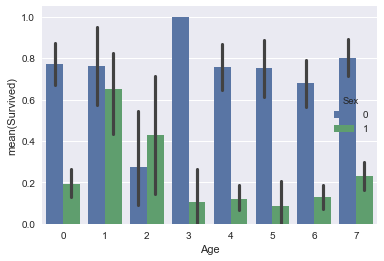

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.barplot(x="Age", y="Survived", hue="Sex", data=data_train);

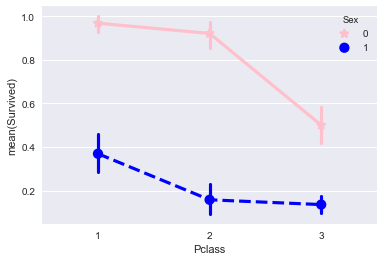

In [15]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train,
              palette={1: "blue", 0: "pink"},
              markers=["*", "o"],
              linestyles=["-", "--"]
             );

# データ可視化の結果について考察 ★
- 上記の２つの可視化から分かったことについて考察せよ。
- 上記の考察結果から、モデル選択を考える場合、どのようなことが考えられるか

**回答**
- 全体を通して、男性よりも女性の生存率が高い
- 乳幼児生存率は男女ともに高い
- こどもの生存率は男性が高く、それ以外の年齢層はいずれも女性が圧倒的に高い
- 高客室であるほど生存率が高い

# データセットの分割
学習データとテストデータの比は8:2とします。

In [16]:
from sklearn.model_selection import train_test_split

X = data_train.drop(['Survived', 'PassengerId'], axis=1)
y = data_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

# ランダムフォレストについて ★

- 決定木とはどのような手法か
- ランダムフォレストとはどのような手法か
- ランダムフォレストの長所と短所をそれぞれ3つ以上挙げてください。
- 今回の目的からランダムフォレストの手法が適する理由を考察し、記述せよ

※決定木とランダムフォレストについては、前述のモデル選択について記述せよにおいて記述していた場合、同じものを記述しても構いません。


決定木とは、**目的変数に属する確率を複数の説明変数の組み合わせで算出**する方法であり、  
ランダムフォレストは**複数の決定木モデルを集めて構成されたモデル**を使って、確率を算出する方法であり、アンサンブル学習のひとつである。  

またランダムフォレストは学習の際、説明変数をランダムに選んで、各決定木モデルを作成する。
- 説明変数どうしに相関があると、弱学習器（決定木）間にも相関が生まれ、別のデータで予測すると誤差が発生する。（汎用性がない）  
- 説明変数をランダムに選ぶことで、相関の低い決定木群を作成し、別データでの誤差を下げ、汎用性を保持


**メリット**  
- ノイズに強い
- 高精度・表現力も高い
- 並列化が容易→データ量が多くても高速に動く
- どの特徴量が重要かを知ることができる


**デメリット**  
- パラメータが多い（木の数や使用する説明変数の数）
- データと説明変数をランダム抽出するため、データと変数が少なすぎるとうまく学習できない
- 複雑なデータではSVMなどの分類手法に比べて汎化性能が下がる



決定木について  
https://dev.classmethod.jp/machine-learning/2017ad_20171211_dt-2/


# 学習
ランダムフォレストを使用して学習する。

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [33]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=15,criterion='entropy', random_state=0)
clf.fit(X_train, y_train)

# score：mean accuracyを出力
print("train accuracy：" + str(clf.score(X_train, y_train)))
print("test accuracy：" + str(clf.score(X_test, y_test)))

train accuracy：0.9705056179775281
test accuracy：0.8044692737430168


# accuracy

In [31]:
y_pred=clf.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test, y_pred)
print("accuracy："+ str(accuracy))

accuracy：0.8044692737430168


# ハイパーパラメータについて ★
- ハイパーパラメーターとは何か
- ランダムフォレストにおいてどのようなハイパーパラメーターがあるか4つ以上記述せよ
- 記述したハイパーパラメーターにおいて、それぞれどのような値が存在するか記述せよ（そのハイパーパラメーターを変化させるとどのようなことが起きるかも記述すること）

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

**回答**  
ハイパーパラメータとは、機械学習アルゴリズムが学習を行う際に、人間が予め設定しなければならないパラメータのことであり、モデルの精度に関わる。

'n_estimators': [4, 6, 9],  
'max_features': ['log2', 'sqrt','auto'],  
'criterion': ['entropy', 'gini'],  
'max_depth': [2, 3, 5, 10],  
'min_samples_split': [2, 3, 5],  
'min_samples_leaf': [1,5,8]

# チューニング
思うような精度が出ていない場合、チューニングを行う必要があります。  
今回はハイパーパラメーターを変更し、チューニングを行いましょう。

- 'n_estimators': [4, 6, 9],
- 'max_features': ['log2', 'sqrt','auto'],
- 'criterion': ['entropy', 'gini'],
- 'max_depth': [2, 3, 5, 10],
- 'min_samples_split': [2, 3, 5],
- 'min_samples_leaf': [1,5,8]

In [20]:
from sklearn.grid_search import GridSearchCV
# from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

tuned_parameters = [{
    'n_estimators': [4, 6, 9],
    'max_features': ['log2', 'sqrt','auto'],
    'criterion': ['entropy', 'gini'],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1,5,8]
}]

clf = GridSearchCV(RandomForestClassifier(),
                   tuned_parameters,
                   scoring= 'accuracy',
                   cv=None,
                   )

clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [4, 6, 9], 'max_features': ['log2', 'sqrt', 'auto'], 'criterion': ['entropy', 'gini'], 'max_depth': [2, 3, 5, 10, 15], 'min_samples_split': [2, 3, 5], 'min_samples_leaf': [1, 5, 8]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [22]:
clf.grid_scores_

[mean: 0.76966, std: 0.03767, params: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 4},
 mean: 0.77528, std: 0.02776, params: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 6},
 mean: 0.79494, std: 0.00495, params: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 9},
 mean: 0.78230, std: 0.01858, params: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 4},
 mean: 0.79494, std: 0.02249, params: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 6},
 mean: 0.79354, std: 0.01476, params: {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 

In [23]:
clf.best_score_

0.827247191011236

In [24]:
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 3,
 'n_estimators': 4}

# 検証
- 検証は何か
- なぜ検証を行う必要があるのか（Accuracyだけではダメな理由も含めること）
- 主な検証方法について2つ以上記述せよ

**回答**  
検証とは、**モデルの汎用性チェック**のことである。  
いくらモデルのAccuracyが高くても、それは取得データ内での正解率であり、  
限られたデータ以外でも、正常に正解を出力できるか確認しなければならない。

主な検証方法として、下記が挙げられる。
- ホールドアウト法
- K-分割交差検証

# KFoldについて
今回はKFold（K-分割交差検証）を使用して、検証を行います。

- K-分割交差検証について説明せよ
- K-分割交差検証はデータセットを何個に分割するか
- データセットを分割する際、その個数はどのように考えると良いか
- K-分割交差検証は何回の検証を行うか
- K-分割交差検証の結果は、最終的にどのように求められるか

**回答**  
k-分割交差検証とはトレーニングデータをk分割し、k-1個を学習用に残りをテストに使用  
これにより、k回の学習とテストを行うことができ、それらの平均と標準偏差を算出する。  
通常kの値は10前後になり、データが多い場合はkの値を増やした方が良い。  
但し、k値を大きくし過ぎると過学習が高くなり、逆にk値を低くしすぎると未学習の可能性がある。

## KFold実施
Kfoldの結果(Mean Accuracy)が75%以上になっていれば成功です。  
そうでなければ、再度モデルのチューニングを行いましょう。

In [25]:
#X_test=X_test.reset_index().drop("index", axis=1)

In [25]:
from sklearn import model_selection
from sklearn.metrics import mean_squared_error

n_fold = 5 # 交差検定の回数
k_fold = model_selection.KFold(n_splits = n_fold)

# aaa=X_test.reset_index().drop("index", axis=1)

accuracy_score_list=[]
X_array=X.values
y_array=y.values
for train, test in k_fold.split(X_array):
    pred = clf.predict(X_array[test])
    accuracy_score_list.append(accuracy_score(y_array[test], pred))
    
print('Mean：' + str(np.mean(accuracy_score_list)))
print('Standard：' + str(np.std(accuracy_score_list)))
 

Mean：0.8372418555018518
Standard：0.018949894855950455


In [27]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8044692737430168

## どの特徴量が重要であったかを調査する
sklearnでランダムフォレストを実装すると用意にどのどの特徴量が重要であったかを判明させることができます。  
feature_importances_メソッドを使用して、判明させましょう。

In [26]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
    criterion='entropy', 
    max_depth=15, 
    max_features='sqrt', 
    min_samples_leaf=5, 
    min_samples_split=3, 
    n_estimators=9, 
    random_state=0
)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=15, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=9, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [27]:
# 個々の特徴量がどの程度重要かを示す割合
clf.feature_importances_

array([0.08549931, 0.34743698, 0.06857767, 0.05848   , 0.024868  ,
       0.06127156, 0.08812736, 0.15040355, 0.11533556])

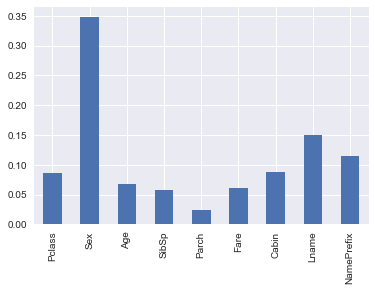

In [28]:
data = pd.Series(clf.feature_importances_, index=list(X.columns[:9]))
data.plot(kind='bar')